Hypothesis Testing

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import openpyxl
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

In [6]:
CHR = pd.read_excel("CountyHealthNew.xlsx")

Subset to counties with RUCC codes 4-9

In [8]:
CHRRur = CHR[CHR["RUCC"].isin([4, 5, 6, 7, 8, 9])].copy()

Median value of child poverty rate across 45 WI counties

In [9]:
poverty_col = "% Children in Poverty"
mhprov_col = "# Mental Health Providers"

median_poverty = CHRRur[poverty_col].median()
print("Median % Children in Poverty:", median_poverty)

Median % Children in Poverty: 15.8


Codes child poverty rate into 2 groups using the median cutoff (15.8)

In [10]:
cutoff = 15.8
CHRRur["Poverty"] = np.where(CHRRur[poverty_col] < cutoff, "Below", "Above")

T-test

In [ ]:
t_stat, p_value = ttest_ind(
    CHRRur.loc[CHRRur["Poverty"] == "Below", mhprov_col],
    CHRRur.loc[CHRRur["Poverty"] == "Above", mhprov_col],
    equal_var=False, 
    #mean(Below) < mean(Above)         
    alternative="less"        
)

print("t =", t_stat)
print("one-sided p =", p_value)


t = 4.128526738483224
one-sided p = 0.9998731530544198


Pearson Correlation

In [ ]:
corr = CHRRur[[mhprov_col, poverty_col]].dropna()

r, p_value = pearsonr(
    corr[mhprov_col],
    corr[poverty_col],
    alternative="less"
)

print("r =", r)
print("one-sided p =", p_value)


r = -0.4295084326148339
one-sided p = 0.0016181689687597507


Log-transform child poverty rate for viz

In [15]:
CHRRur["PovertyLog"] = np.log(CHRRur[poverty_col])

Viz

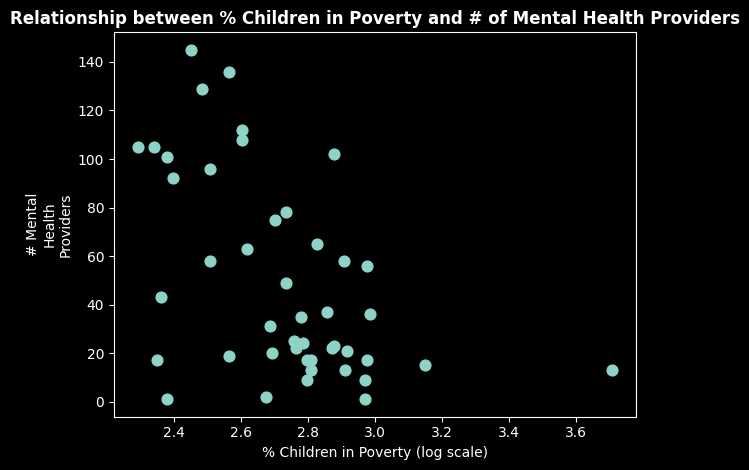

In [16]:
plt.figure()
plt.scatter(CHRRur["PovertyLog"], CHRRur[mhprov_col], s=60)  # size ~ 2.5 in ggplot-ish
plt.title("Relationship between % Children in Poverty and # of Mental Health Providers", fontweight="bold")
plt.xlabel("% Children in Poverty (log scale)")
plt.ylabel("# Mental\nHealth\nProviders")
plt.tight_layout()
plt.show()
